In [53]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision.datasets as datasets  
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [55]:
Features = pd.read_csv('./features_train.csv')
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.309191,0.627918,0.581373,0.631953,0.722411,0.627493,0.665136,0.622326,0.592026,0.646436,...,0.000016,0.000009,0.000012,0.000016,0.000034,0.000023,0.000006,1.665318e-07,2.238974e-09,neutral
1,0.266317,0.647447,0.617845,0.651958,0.741533,0.690169,0.680209,0.620544,0.574914,0.624773,...,0.000016,0.000009,0.000013,0.000017,0.000034,0.000024,0.000006,4.286272e-07,2.661373e-07,neutral
2,0.187334,0.590202,0.597529,0.587395,0.672896,0.675208,0.585603,0.620581,0.580191,0.596872,...,0.000024,0.000004,0.000003,0.000001,0.000005,0.000002,0.000001,4.699898e-08,2.571243e-10,neutral
3,0.181442,0.547213,0.531296,0.639458,0.587223,0.576165,0.671551,0.637666,0.591458,0.606419,...,0.000039,0.000040,0.000152,0.000513,0.000980,0.000364,0.000040,6.251843e-07,3.243000e-09,neutral
4,0.158361,0.541172,0.530813,0.640595,0.593274,0.586583,0.665802,0.628927,0.588682,0.601577,...,0.000039,0.000040,0.000152,0.000513,0.000980,0.000364,0.000040,6.350595e-07,1.372913e-08,neutral


In [56]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        self.conv1 = conv3x3(inplanes, planes, stride)  
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 162 # input feature map
        self.dilation = 1

        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []

        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion 

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model

def resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress, **kwargs)

In [57]:
from torch.utils.data import random_split
batch_size = 100

X = torch.cuda.FloatTensor(Features.iloc[: ,:-1].values)
Y = Features['labels'].values
encoder = LabelEncoder()
Y = torch.cuda.LongTensor(encoder.fit_transform(np.array(Y).reshape(-1,1)))

dataset = list(zip(X,Y))
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
print('train_size :', len(train_dataset))
print('valid_size :', len(valid_dataset))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_size : 23323
valid_size : 5831


In [58]:
batch_size = 100
num_epoch = 30
lr = 1e-4
wd = 1e-6

model = resnet34().to(device=device)
model_opt = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(model_opt, T_max=3, eta_min=1e-5)
criterion = nn.CrossEntropyLoss().to(device=device)

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for i in range(num_epoch):
    epoch_loss = 0
    predictions = []
    labels = []
    for idx, data in enumerate(train_loader):
        train_x, train_y = data
        x = train_x.to(device=device)
        y= train_y.to(device=device)
        model_opt.zero_grad()
        x = x.unsqueeze(-2)
        x = x.unsqueeze(-1)
        # print(x.shape)
        output = model(x)
        loss = criterion(output,y)
        loss.backward()
        model_opt.step()
        schedular.step()
        epoch_loss += loss.item()
        predictions.append(torch.argmax(torch.nn.functional.softmax(output), dim=-1).detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())
    print('Training Epoch', i+1, ' loss:', epoch_loss / (idx+1))
    predictions = np.hstack(predictions)
    labels = np.hstack(labels)   
    train_loss.append(epoch_loss / (idx+1))
    train_acc.append(accuracy_score(labels, predictions))
    print('Accuracy:', accuracy_score(labels, predictions))

    with torch.no_grad():
        epoch_loss = 0
        predictions = []
        labels = []
        for idx, data in enumerate(valid_loader):
            valid_x, valid_y = data
            x = valid_x.to(device=device)
            y= valid_y.to(device=device)
            x = x.unsqueeze(-2)
            x = x.unsqueeze(-1)
            output = model(x)
            loss = criterion(output,y)
            epoch_loss += loss.item()
            predictions.append(torch.argmax(torch.nn.functional.softmax(output), dim=-1).detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
        print('Validation Epoch', i+1, ' loss:', epoch_loss / (idx+1))
        predictions = np.hstack(predictions)
        labels = np.hstack(labels)   
        valid_loss.append(epoch_loss / (idx+1))
        valid_acc.append(accuracy_score(labels, predictions))
        print('Accuracy:', accuracy_score(labels, predictions))

Training Epoch 1  loss: 1.5227528000489259
Accuracy: 0.40436479012133947
Validation Epoch 1  loss: 1.2820693880824718
Accuracy: 0.5088321042702796
Training Epoch 2  loss: 1.2583119357243562
Accuracy: 0.5067958667409853
Validation Epoch 2  loss: 1.1934414111961753
Accuracy: 0.5314697307494426
Training Epoch 3  loss: 1.1659540355714977
Accuracy: 0.541525532735926
Validation Epoch 3  loss: 1.1272150682190718
Accuracy: 0.5499914251414851
Training Epoch 4  loss: 1.1178045670191448
Accuracy: 0.5565321785362088
Validation Epoch 4  loss: 1.1273809135970423
Accuracy: 0.5551363402503858
Training Epoch 5  loss: 1.0728653992852595
Accuracy: 0.5765124555160143
Validation Epoch 5  loss: 1.0839777841406353
Accuracy: 0.571085577087978
Training Epoch 6  loss: 1.0239301461439867
Accuracy: 0.5964498563649616
Validation Epoch 6  loss: 1.0639162498005366
Accuracy: 0.5866918195849768
Training Epoch 7  loss: 0.9835308950680953
Accuracy: 0.6133001757921365
Validation Epoch 7  loss: 1.0473305603205147
Accuracy

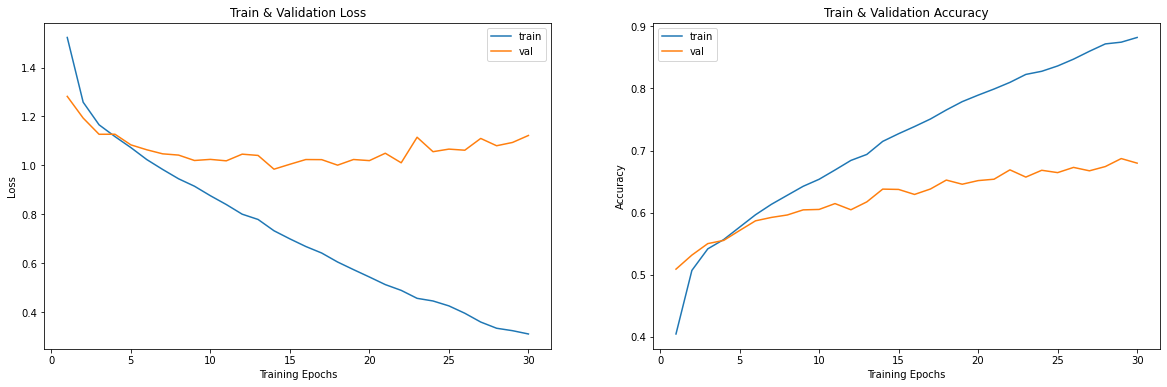

In [59]:
fig , ax = plt.subplots(1,2)

fig.set_size_inches(20,6)
ax[0].plot(range(1,num_epoch+1),train_loss,label="train")
ax[0].plot(range(1,num_epoch+1),valid_loss,label="val")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Training Epochs")
ax[0].set_title('Train & Validation Loss')
ax[0].legend()

ax[1].plot(range(1,num_epoch+1),train_acc,label="train")
ax[1].plot(range(1,num_epoch+1),valid_acc,label="val")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Training Epochs")
ax[1].set_title('Train & Validation Accuracy')
ax[1].legend()

plt.show()

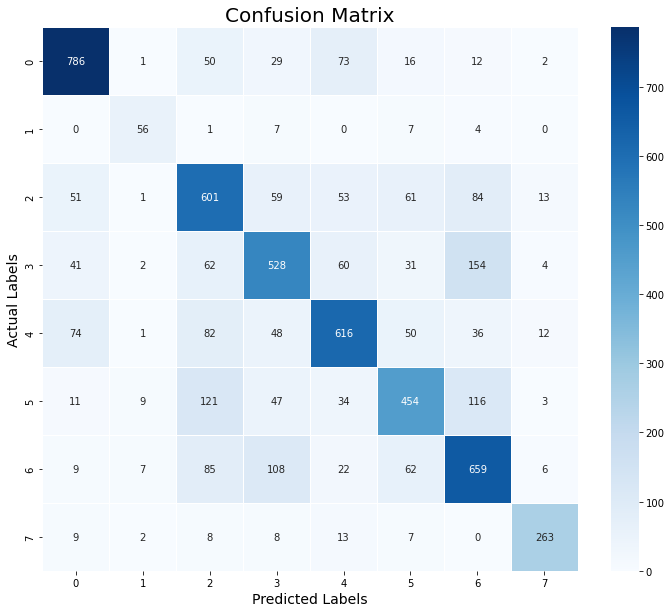

In [60]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()